# Natural Language Generation
Teaching a computer to describe a dataset. There is an IDE for this stuff somewhere, but IDEs are cheating. And I don't like learning how to use them. So we have a dataset for an off license, this csv has data on products, their price and how many sales they've made this week.
As a simple first milestone, we want our program to tell us what the top selling product is
- https://github.com/gramener/gramex-nlg/tree/dev#glossary-grammar-of-data-driven-narratives
- https://github.com/explosion/spaCy/issues/4577  

We'll then move onto some simple techniques like tokenizing and breaking sentences up into parts of speech to see if we can descibe a block of text without using templates

In [434]:
from gramex.data import filter as gfilter
from nlg.search import templatize
from nlg.utils import load_spacy_model
from nltk.corpus import wordnet
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import numpy as np
import re

In [435]:
# read in our csv and print the preview
df = pd.read_csv('offlicense.csv')
df

,category,name,price,sales
0,alcohol,carlsberg,4.05,402
1,alcohol,heineken,3.95,100
2,snacks,tayto,1.20,300
3,alcohol,miller,3.80,40
4,alcohol,metalman,4.10,200
5,snacks,peanuts,1.10,110
6,alcohol,bulmers,4.90,330
7,alcohol,hoegarden,4.50,475
8,snacks,popcorn,2.00,80
9,snacks,chips,3.00,70


The table shows us the list of producst, their category, price and sales. We'll apply the gramex filter and sort the dataframe by sales. The hypen before sales indicates descending order

In [436]:
sort_args = {'_sort': ['-sales']}
xdf = gfilter(df, sort_args.copy())
xdf.head()

,category,name,price,sales
7,alcohol,hoegarden,4.50,475
0,alcohol,carlsberg,4.05,402
6,alcohol,bulmers,4.90,330
2,snacks,tayto,1.20,300
4,alcohol,metalman,4.10,200


In [437]:
xdf.describe()

,price,sales
count,12.000000,12.000000
mean,3.258333,193.083333
std,1.279708,151.913527
min,1.100000,10.000000
25%,2.375000,77.500000
50%,3.875000,155.000000
75%,4.062500,307.500000
max,4.900000,475.000000


Best seller is is hoegarden


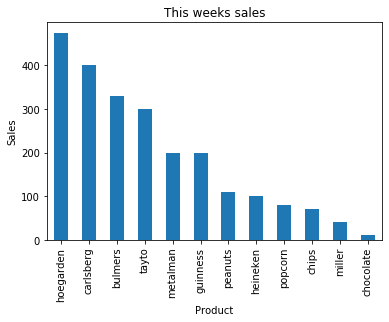

In [438]:
print("Best seller is is {}".format(xdf.iloc[0]["name"]))
fig, ax = plt.subplots()
xdf.sort_values(by="sales",ascending=False)['sales'].plot.bar();
ax.set_xticklabels(xdf.sort_values(by="sales",ascending=False)['name'])
plt.title("This weeks sales")
plt.ylabel("Sales")
plt.xlabel("Product")
plt.show()

## lets show this program how its done
we'll describe the data manually and see if the big python in the sky catches on with what we're trying to do

In [439]:
nlp = load_spacy_model()
text = nlp("hoegarden has the highest alcohol sales")

In [441]:
nugget = templatize(text, sort_args, df)
nugget

{% set fh_args = {"_sort": ["-sales"]}  %}
{% set df = U.gfilter(orgdf, fh_args.copy()) %}
{% set fh_args = U.sanitize_fh_args(fh_args, orgdf) %}
{# Do not edit above this line. #}
hoegarden has the highest {{ df["category"].iloc[-2] }} {{ fh_args['_sort'][0] }}

In [442]:
nugget.variables

{sales: {{ fh_args['_sort'][0] }}, alcohol: {{ df["category"].iloc[-2] }}}

Something isn't quite right here. We can see that its picked up on the sort filter but not on the name of the best selling product. It's also interpreted the word *alcohol* incorrectly, its created an alcohol variable and found the word alcohol and marked its exact location instead of just the column. We update the alcohol variable first

In [443]:
var = nugget.get_var('alcohol')
var.set_expr('df["category"].iloc[0]')

Next we add the name variable, we mark the token as the first word in our sentence, give it a name and added it to our template.

In [444]:
var_token = text[0]
var_expr = 'df["name"].iloc[0]'

nugget.add_var(var_token, expr=var_expr)
nugget

{% set fh_args = {"_sort": ["-sales"]}  %}
{% set df = U.gfilter(orgdf, fh_args.copy()) %}
{% set fh_args = U.sanitize_fh_args(fh_args, orgdf) %}
{# Do not edit above this line. #}
{{ df["name"].iloc[0] }} has the highest {{ df["category"].iloc[0] }} {{ fh_args['_sort'][0] }}

## Now we're on the trolley! 
Excellent, lets use our template to render a summary of the dataframe

In [445]:
print(nugget.render(df))

b'    hoegarden has the highest alcohol sales'


Nice ! It printed out exactly what we typed in . . . .  
So to check that something is actually working here, we will fill our dataframe with random data and we'll try to apply our template to this one

In [446]:
np.random.seed(12345) # classic seed 
fake_sales = df.copy()
fake_sales['sales'] = np.random.randint(2000,size=df.shape[0])
fake_sales.sort_values('sales', ascending=False)

,category,name,price,sales
9,snacks,chips,3.00,1565
1,alcohol,heineken,3.95,1509
5,snacks,peanuts,1.10,1449
4,alcohol,metalman,4.10,1444
7,alcohol,hoegarden,4.50,1381
2,snacks,tayto,1.20,1309
11,snacks,chocolate,2.50,1142
10,alcohol,guinness,4.00,769
8,snacks,popcorn,2.00,546
0,alcohol,carlsberg,4.05,482


## APPLY THE TEMPLATE !

In [447]:
nugget.render(fake_sales)

b'    chips has the highest snacks sales'

Nice ! We'll change our template a little to use price instead of sales and see if we can still accurately describe the dataset

In [448]:
nugget.fh_args = {'_sort': ['-price']}
nugget.render(df)

b'    bulmers has the highest alcohol price'

It successfully reports that bulmers has the highest price in our dataset. Nice !

# Less templatey approach
Next up, we'll see if we take a block of text and only pull the *most* useful information from it. In this case we'll say it's an excerpt from the official financial times blog. Everyone wants to know whats in it, but nobody wants to actually read it. As a savvy investor with no time to waste, I just want the computer to read the article and tell me what to do. Buy, Sell, Short, Long, Bull, Bear, and all that other stuff I learned in investment school.
- we'll use [wordnet](https://www.nltk.org/howto/wordnet.html) to build a list of words associated with good and bad signs
- then we'll read the article, removing stop words. For an intro to stop words, here's a [website you may have heard of](https://en.wikipedia.org/wiki/Stop_words) that explains what they are
- next’s  up we'll break the text up into n-grams (sequences of words)
- we'll filter our ngrams by ones that have good words and bad words, and remove sequences that have neither
- we'll score our ngrams based on their sentiment and descriptiveness using some scoring system i made up just now 
 - the higher the noun count, the higher the descriptive score
 - the higher the count of good/bad words, the higher the sentiment score 
- We'll convert our ngram sets to dataframes, sort them by their scores and print information on the top scores

In [449]:
good_synonyms = set()
bad_synonyms = set()

for syn in wordnet.synsets("good"):
    good_synonyms.update(list(map(lambda x: x.name().lower().replace('_',' '), syn.lemmas())))
for syn in wordnet.synsets("positive"):
    good_synonyms.update(list(map(lambda x: x.name().lower().replace('_',' '), syn.lemmas())))
print(good_synonyms)

for syn in wordnet.synsets("bad"):
    bad_synonyms.update(list(map(lambda x: x.name().lower().replace('_',' '), syn.lemmas())))
for syn in wordnet.synsets("negative"):
    bad_synonyms.update(list(map(lambda x: x.name().lower().replace('_',' '), syn.lemmas())))
print(bad_synonyms)

{'safe', 'commodity', 'good', 'electropositive', 'confident', 'confirming', 'trade good', 'expert', 'salutary', 'honest', 'respectable', 'convinced', 'honorable', 'in force', 'secure', 'effective', 'ripe', 'sound', 'upright', 'dependable', 'goodness', 'skillful', 'in effect', 'plus', 'prescribed', 'just', 'unspoilt', 'positivistic', 'positively charged', 'skilful', 'adept', 'well', 'positive', 'practiced', 'overconfident', 'proficient', 'beneficial', 'undecomposed', 'right', 'incontrovertible', 'unspoiled', 'near', 'thoroughly', 'irrefutable', 'full', 'positivist', 'estimable', 'positive degree', 'dear', 'soundly', 'serious', 'cocksure'}
{'blackball', 'spoiled', 'tough', 'uncollectible', 'negative', 'sorry', 'veto', 'electronegative', 'big', 'risky', 'negatively charged', 'minus', 'badly', 'regretful', 'defective', 'forged', 'unsound', 'disconfirming', 'speculative', 'unfit', 'high-risk', 'spoilt', 'damaging', 'bad', 'badness'}


In [450]:

locale = 'english'
stop_words = stopwords.words(locale)

sentence = """greetings to first time readers this blog aims to inform you of 
useful stuff. In todays financial news experts are predicting chicken goujons are a safe and secure bet.
i am particularly speculative of investments in antique typewriters 
and i believe calculators are still risky in the long term.
However with regard to precious metals, the returns are at all time high, our resident expert predicts gold prices will soar"""
sentence = sentence.lower()
tokens = [token for token in word_tokenize(sentence) if token not in stop_words]


all_news = list(ngrams(tokens, 5))

### function filters down the news using a list of synonyms  
Uses [parts of speech](https://medium.com/@gianpaul.r/tokenization-and-parts-of-speech-pos-tagging-in-pythons-nltk-library-2d30f70af13b) to find the descriptive words in each news snippet. Generates a descriptive score based on how many words can describe the news state, and generates a sentiment score based on how many words in the provided synonym list appear in the snipped

In [483]:
def generate_news_data_frame(synonyms):
    filtered_news = [
        headline for headline in all_news if 
        any(substring in headline for substring in synonyms)
        and "." not in headline]
    scores = []
    nouns = []
    adjectives = []
    for news in filtered_news:
        local_count = 0
        local_nouns = []
        local_adjectives = []
        toks = word_tokenize(" ".join(list(news)))
        # https://medium.com/@gianpaul.r/tokenization-and-parts-of-speech-pos-tagging-in-pythons-nltk-library-2d30f70af13b
        pos = nltk.pos_tag(toks)
        local_nouns = [w[0] for w in pos if w[1] in ['NN','NNS']]
        local_verbs = [w[0] for w in pos if w[1] in ['VB','VBD','VBG','VBN','VBP','VBZ']]
        for word in news:
            if word in synonyms:
                local_verbs.append(word)
                local_count += 1
        scores.append(local_count)
        nouns.append(set(local_nouns))
        adjectives.append(set(local_verbs))
    filtered_df = pd.DataFrame.from_records(filtered_news)
    filtered_df["adjectives"] = adjectives
    filtered_df["nouns"] = nouns
    filtered_df["descriptive_score"] = filtered_df.apply(lambda row: len(row["nouns"]), axis=1)
    filtered_df["sentiment_score"] = scores
    filtered_df = filtered_df.sort_values(by=['sentiment_score', 'descriptive_score'], ascending=False)
    return filtered_df



In [484]:
# generate a dataframe, using our good synonyms to filter out good news
good_df = generate_news_data_frame(good_synonyms)
good_df

,0,1,2,3,4,adjectives,nouns,descriptive_score,sentiment_score
2,chicken,goujons,safe,secure,bet,"{safe, secure}","{bet, goujons, chicken, secure}",4,2
1,predicting,chicken,goujons,safe,secure,"{safe, secure, predicting}","{secure, goujons}",2,2
6,resident,expert,predicts,gold,prices,"{predicts, expert}","{resident, expert, prices, gold}",4,1
5,",",resident,expert,predicts,gold,"{predicts, expert}","{resident, expert, gold}",3,1
0,experts,predicting,chicken,goujons,safe,"{safe, predicting}","{goujons, experts}",2,1
3,time,high,",",resident,expert,{expert},"{expert, time}",2,1
4,high,",",resident,expert,predicts,{expert},"{predicts, expert}",2,1
7,expert,predicts,gold,prices,soar,"{predicts, expert, soar}","{expert, prices}",2,1


In [486]:
# generate a dataframe, using our bad synonyms to filter out bad news
bad_df = generate_news_data_frame(bad_synonyms)
bad_df

,0,1,2,3,4,adjectives,nouns,descriptive_score,sentiment_score
0,particularly,speculative,investments,antique,typewriters,{speculative},"{investments, typewriters}",2,1
1,speculative,investments,antique,typewriters,believe,"{believe, speculative}","{investments, typewriters}",2,1
2,typewriters,believe,calculators,still,risky,"{believe, risky}","{calculators, typewriters}",2,1
3,believe,calculators,still,risky,long,{risky},"{believe, calculators}",2,1
4,calculators,still,risky,long,term,{risky},"{calculators, term}",2,1


## preliminary analysis
So looking at the rows of our good and bad datasets   
#### We get useful good snippets like 
- chicken goujons safe secure bet - {safe, secure} {chicken, goujons}
- experts predicting chicken goujons safe - {safe, secure} {goujons}
- expert predicts gold prices soar - {predicts, experts, soar} {prices}

#### We also get useful bad snippets like  
- particular speculative investments antique typewriters - {speculative} {investments, typewriters}
- calculators still risky long term - {risky} {calculators}  

#### On the other hand, some fairly useful data has crept in
- high resident expert predicts   

Overall though, by scanning the nouns column, we can get a good feel for what the ngram is about, looking across the row gives more context and allows us quickly to make decisions like  
- buy chicken goujons
- buy gold
- do not buy typewriters, sell any existing shares/stock
- do not buy calculators, sell any existing shares/stock  

## Thats still a lot of work, how about a picture ?

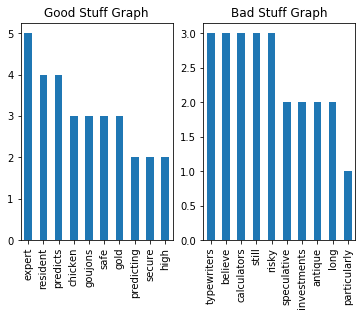

In [487]:
def generate_sneak_peak_df(news):
    sneak_preview_data = " ".join([item for sublist in news for item in sublist])
    clean_vocab = re.sub("(\\W|\\d)"," ",sneak_preview_data).strip().split(" ")
    clean_vocab = list(filter(None, clean_vocab))
    counter = Counter(clean_vocab)
    top_words = counter.most_common(10)

    word_count = []
    for top_word in top_words:
        word_count.append({"word": top_word[0], "count": top_word[1]}) 
    return pd.DataFrame(word_count,columns=['word','count'])

   
good_word_count_df= generate_sneak_peak_df(good_news)
bad_word_count_df=generate_sneak_peak_df(bad_news)

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)

good_word_count_df["count"].plot.bar();
ax1.set_xticklabels(good_word_count_df["word"])
plt.title("Good Stuff Graph")

ax2 = fig.add_subplot(1, 2, 2)
bad_word_count_df["count"].plot.bar();
ax2.set_xticklabels(bad_word_count_df["word"])
plt.title("Bad Stuff Graph")
plt.show()

Excellent, not perfect, but we can still maybe get something useful stuff here  
- expert resident predicts chicken goujons safe
- gold predicting secure high
- typewriters believe calculators still risky investments
- antique long particularly  
### ok maybe don't base your investment strategy on what gold is predicting or what typewriters believe. These graphs need some context. Lets take our two datasets and print out a single line summary for each.

In [492]:
good = good_df.iloc[0]
bad = bad_df.iloc[0]
print("the good news is i'm getting {} vibes off {}".format(good["adjectives"], good["nouns"]))
print("the bad news is i'm getting {} vibes off {}".format(bad["adjectives"], bad["nouns"]))

the good news is i'm getting {'safe', 'secure'} vibes off {'bet', 'goujons', 'chicken', 'secure'}
the bad news is i'm getting {'speculative'} vibes off {'investments', 'typewriters'}


So you heard it here first. Go buy some chicken goujons and stay away from those typewriters.